In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
import itertools
plotmarkers=['^-', 'o-', 's-', '*-', 'd-', 'v-', 'h-', '>-', 'D-', 'H-', '<-', 'o-', 's-', '3-']
from scipy.optimize import curve_fit
import csv
%matplotlib inline


figsizeRanb=(5, 3.5)#(6,4) is default size in inches
plt.rcParams.update({'font.size': 11}) #default is 10

from matplotlib.ticker import AutoMinorLocator  #Stuff for ticks
minorLocator = AutoMinorLocator(2)

    
rootTP="/home/johann/Remote/imac"
rootTP2="/home/johann/Remote2"
rootMAC="/Users/jh"
root=rootMAC



In [78]:
# Function to plot D over phi vary lub noLub data with fixed aop
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phiOverlap(aob): # Old formula for phi for overlapping cylinders
    return (3*Vcyl(aob,b=1) - 8 * np.sqrt(2) * (aob/2.)**3)

def phiNoOverlap(aob): 
    return 3*Vcyl(aob,b=1) # This is almost the same formula as for the old model, but without the overlap term

def ptoPhiOverlap(aprel,aop,zeroa=False):
    if zeroa:
        prel=aprel/(1.+aop)
    return phiOverlap(prel*aop)

def ptoPhiNoOverlap(aprel,aop,zeroa=False):
    if zeroa:
        prel=aprel/(1.+aop)
    return phiNoOverlap(prel*aop)

def ptoPhiData(data,aop=0,zeroa=False,zerop=False):
    prels=data[:,0]
    if zeroa:
        prels/=(1.+aop)
    elif zerop:
        aop=1
    phis=phiOverlap(prels*aop)
    data[:,0]=phis

In [ ]:
def plottofile(filename):
    pp = PdfPages('figures/'+filename+'.pdf')
    pp.savefig(bbox_inches='tight')
    pp.close()

## Some Notes:
#### The aim: Comparing Ranb D over phi data to fig.4 in our bpj paper.
In Johansson1991 some quantities for dextran are given as: 
- the partial specific volume $\nu_s=0.61$ mL/g
- the dextran diameter $a=7.4$ Angstrom
- the dextran mean residue length $l=3.9$ Angstrom

Using the former two quantities, we can calculate the dextran volume fraction $\phi$ from the weight volume percentage (g/mL x 100):
$$\phi = \frac{(w/v)\% \times \nu_s}{100} \;=\; (w/v)\% \times 0.0061$$

According to Jason and our previous papers, Alexa has a diameter of 14 to 15 Angstrom. Hence we obtain an $a/p$ ratio of:
- $a/p = 0.5$ *without* a water hydration layer and $(a+p)=(0.74+1.48)nm = 2.22nm$
- $a/p = \frac{7.4 + 4}{15} = 0.75$ *with* water hydration layer and $(a+p)=(1.14+1.48)nm = 2.62nm$

Maximal phi for Jason Data:  0.0488


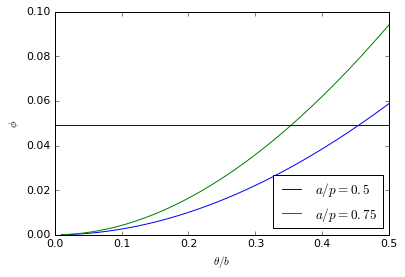

For a/p=0.5, the maximal value of is (a+p) = 0.4537
For a/p=0.75, the maximal value of is (a+p) = 0.3529


In [80]:
print('Maximal phi for Jason Data: ',0.0061*8)

ptest=np.arange(0.01,0.5,0.0001)
plt.plot(ptest,ptoPhiOverlap(ptest,0.5,True),label='$a/p=0.5$')
plt.plot(ptest,ptoPhiOverlap(ptest,0.75,True),label='$a/p=0.75$')
plt.axhline(0.049)
plt.legend(loc=4)
plt.xlabel(r'$\theta/b$')
plt.ylabel(r'$\phi$')
plt.xlim([0,0.5])
plt.show()

phiVals=ptoPhiOverlap(ptest,0.5,True)
xint_i= (np.abs(phiVals-0.049)).argmin(0)
print("For a/p=0.5, the maximal value of is (a+p) =", ptest[xint_i])

phiVals=ptoPhiOverlap(ptest,0.75,True)
xint_i= (np.abs(phiVals-0.049)).argmin(0)
print("For a/p=0.75, the maximal value of is (a+p) =", ptest[xint_i])

### Conclusion:
We determined maximal $\theta=(a+p)$ value for the polymer concentration interval interval of Jasons experiment for Alexa in charged Dextran (Fig.4 bpj). For $a/p=0.5$ *without* water hydration layer, and $a/p=0.75$ *with* water hydration layer:
- $a/p=0.5$: about $\theta/b=(a+p)/b=0.45b$
- $a/p=0.75$: about $\theta/b=(a+p)/b=0.35b$

#### Calculate all $a/b$ values from the $\phi$ values 
$$\phi \approx \frac{3V_{cyl}}{V_{box}} = 3\pi \left(\frac{a}{2b}\right)^2$$
$$\rightarrow a/b = 2 \sqrt{\phi/(3\pi)}$$

In [101]:
def floatPrint(data): 
    np.set_printoptions(precision=3)
    print(data)
    np.set_printoptions(precision=8)

def aFromCdextran(Cdextran):
    "a/b is output. Needs Cdextran in g/L"
    phiDex = Cdextran*0.00061
    arel = 2*np.sqrt(phiDex/(3*np.pi))
    return arel

def bnmFromCdextran(Cdextran,anm):
    "a/b is output. Needs Cdextran in g/L"
    phiDex = Cdextran*0.00061
    bnm = anm/(2*np.sqrt(phiDex/(3*np.pi)))
    return bnm

Cvalues = np.arange(10,100,20)
aValues = aFromCdextran(Cvalues)
print("a/b values:")
floatPrint(aValues)


a/b values:
[ 0.051  0.088  0.114  0.135  0.153]


## Next step: Calculate corresponding range $k/p$

At 1 (w/v)% I have 6mM for dex- and 10 mM for dex+.
Hence, I get 

Cion- = (buffer) + (dextran-) = 10mM + (w/v)% x 6mM

Cion+ = (buffer) + (dextran+) = 10mM + (w/v)% x 10mM

where g/mol = 10 x (w/v)%

In [104]:
def kFromCion(Cion):
    "This function returns the interaction range k in nanometers for a certain Ion concentration in mM"
    return np.sqrt(0.0924*10**3/Cion)

def kFromCdextran(Cpoly):
    "This function returns the interaction range k in nanometers for a certain dextran Concentration in g/L"
    Cion_mM_Att = 10 + 10 * Cpoly/10.
    Cion_mM_Rep = 10 + 6  * Cpoly/10.
    kAtt = kFromCion(Cion_mM_Att)
    kRep = kFromCion(Cion_mM_Rep)
    return kAtt, kRep

def koapFromCdextran(Cpoly,apsteric):
    "This function requires the dextran conc. in g/L and the steric interaction param. in nm to calc. k/(a+p)"
    kAtt, kRep = kFromCdextran(Cpoly)
    return kAtt/apsteric, kRep/apsteric

def krelbFromCdextran(Cpoly,anm):
    "This function requires the dextran conc. in g/L and the steric interaction param. in nm to calc. k/(a+p)"
    kAtt, kRep = kFromCdextran(Cpoly)
    print(kAtt)
    print(bnmFromCdextran(Cpoly,anm))
    return kAtt/bnmFromCdextran(Cpoly,anm), kRep/bnmFromCdextran(Cpoly,anm)

katt,krep=kFromCdextran(Cvalues)

np.set_printoptions(precision=3)
print("The absolute ranges k in nm:\n","kAtt =",katt,"\nkRep =",krep)
kAttrel, kReprel = koapFromCdextran(Cvalues,2.22)
print("\nThe relative ranges k/steric for a/p=0.5:\n","kAtt/steric =",kAttrel,"\nkRep/steric =",kReprel)

kAttrel, kReprel = koapFromCdextran(Cvalues,2.62)
print("\nThe relative ranges k/steric for a/p=0.75:\n","kAtt/steric =",kAttrel,"\nkRep/steric =",kReprel)
np.set_printoptions(precision=8)

print(krelbFromCdextran(Cvalues,0.74))

The absolute ranges k in nm:
 kAtt = [ 2.149  1.52   1.241  1.075  0.961] 
kRep = [ 2.403  1.817  1.52   1.333  1.202]

The relative ranges k/steric for a/p=0.5:
 kAtt/steric = [ 0.968  0.685  0.559  0.484  0.433] 
kRep/steric = [ 1.082  0.818  0.685  0.6    0.541]

The relative ranges k/steric for a/p=0.75:
 kAtt/steric = [ 0.82   0.58   0.474  0.41   0.367] 
kRep/steric = [ 0.917  0.693  0.58   0.509  0.459]
[ 2.14941853  1.51986842  1.24096736  1.07470926  0.96124919]
[ 14.54361503   8.39676005   6.50410237   5.49696979   4.84787168]
(array([ 0.14779121,  0.18100653,  0.19079764,  0.1955094 ,  0.19828272]), array([ 0.1652356 ,  0.21634419,  0.23367843,  0.24249956,  0.2478534 ]))


#### Conclusion:
- We find that the interaction range becomes smaller for increasing dextran concentration, since the ion concentration increases simultaneously.
- NOTE: In principle I would need to also adapt the interaction strength $U_0$. The interaction strenght for touching spheres should be similar for varying ion concentration. Hence, when $k/p$ decreases, I should increase $U_0$.
$$U_{01} e^{-\theta/(2k_1)} = U_{02} e^{-\theta/(2k_2)}$$
$$U_{02} = U_{01} e^{-\theta (1/(2k_1) - 1/(2k_2))}$$
$$\rightarrow U_{02} = U_{01} e^{-\theta (k_2 - k_1)/(2k_2k_1)}$$

In [76]:
def Unewk(Uk1,k1,k2,theta=1):
    "This function returns an adapted U_0 for changing interaction range k/p"
    Ufactor = np.exp(-theta*(k2-k1)/(2*k1*k2))
    Unew = Uk1 * Ufactor
    return Unew, Ufactor

Uk1=-5; k1op=1.5; k2op=0.46
Unewk(Uk1,k1op,k2op)

(-10.623421093889213, 2.1246842187778427)